# Build an efficient unsupervised word translator

Based on : "Word Translation Without Parallel Data" by Alexis Conneau, Guillaume Lample, Marc Aurelio Ranzato, Ludovic Denoyer & Hervé Jégou (2017)

In [1]:
import io

import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

from scipy.stats import special_ortho_group
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [2]:
# load function for pretrained versions of word embeddings
def load_embeddings(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [3]:
##########
eng_path = '/Users/louismonier/Downloads/Monolingual/wiki.en.vec' 
fr_path = '/Users/louismonier/Downloads/Monolingual/wiki.fr.vec'
##########
#eng_path = '/Users/vince/DataProjetNLP/wiki.en.vec'
#fr_path = '/Users/vince/DataProjetNLP/wiki.fr.vec'
##########
nmax = 50000  # maximum number of word embeddings to load

# load monolingual word embeddings 
src_embeddings, src_id2word, src_word2id = load_embeddings(fr_path, nmax) # source = french 
tgt_embeddings, tgt_id2word, tgt_word2id = load_embeddings(eng_path, nmax) # target = english

In [4]:
# load ground-truth bilingual dictionaries function
def load_dic(path):
    dico_full = {}
    vectors_src=[]
    vectors_tgt = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ',1)
            if word_tgt in tgt_word2id :
                dico_full[word_src]=word_tgt
    for key in dico_full.keys() :
            vectors_src.append(src_embeddings[src_word2id[key]])
            vectors_tgt.append(tgt_embeddings[tgt_word2id[dico_full[key]]])
    X = np.vstack(vectors_src)
    Z = np.vstack (vectors_tgt)
    return dico_full,X,Z

In [5]:
# train & test bilingual dictionaries
##########
path_train = r'/Users/louismonier/Downloads/Monolingual/fr-en.0-5000.txt' 
path_test = r'/Users/louismonier/Downloads/Monolingual/fr-en.5000-6500.txt'
##########
#path_train = '/Users/vince/DataProjetNLP/fr-en.0-5000.txt' 
#path_test = '/Users/vince/DataProjetNLP/fr-en.5000-6500.txt'
##########

dico_train, X_train, Z_train = load_dic(path_train)
dico_test, X_test, Z_test = load_dic(path_test)

# convert embeddings vectors into torch tensors 
print(type(X_train[0]))
X_train, Z_train, X_test, Z_test = map(torch.tensor, (X_train, Z_train, X_test, Z_test)) 
print(type(X_train[0]))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [6]:
print(X_train.shape[0], "training samples")
print(X_test.shape[0], "test samples")
dim = X_train.shape[1]
print("Vectors dimension :", dim)

4971 training samples
1483 test samples
Vectors dimension : 300


## Build the discriminator 

Recall what is the objective of the discriminator here : ...

In [255]:
class Discriminator(nn.Module):
    def __init__(self, dim):
        super(Discriminator,self).__init__()
        self.h1 = nn.Linear(dim, 2048,bias=True) # 1st hidden layer
        #self.h2 = nn.Linear(2048,2048,bias=True) # 2nd hidden layer
        self.out = nn.Linear(2048,1,bias=True) # output layer
        
    def forward(self, x):
        x = F.dropout(x, p = 0.1) # dropout pour ajouter du bruit
        x = F.leaky_relu(self.h1(x), negative_slope=0.2)
        #x = F.leaky_relu(self.h2(x), negative_slope=0.2)
        y = torch.sigmoid(self.out(x)) # ouput = proba
        return y

## Build the generator 

Recall what is the objective of the discriminator here : ...

In [256]:
# simple linear function 
# can be seen at a neural network whose weights are elements of W 
class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(dim, dim, bias=False)

    def forward(self,x):
        y = self.l1(x)
        return y

## It's time to train 

In [257]:
discrim = Discriminator(dim)
gen = Generator(dim)

In [258]:
LossD = nn.BCELoss()
LossG = nn.BCELoss()

optimD = optim.SGD(discrim.parameters(), lr=0.1)
optimG = optim.SGD(gen.parameters(), lr=0.1)

In [259]:
#for epoch in range(3): #3 Epochs 
LD = []
LG = []

N = 32 # nb of "fake" tgt // Wx
M = 32 # nb of "true" tgt // y

W = special_ortho_group.rvs(dim)
gen.l1.weight.data = torch.tensor(W,dtype=torch.float) # ini of generator's weights in SO(300)
beta = 0.01

for param in discrim.h1.parameters():
    param.data.uniform_(-0.1,0.1)

niter = 500
nb_d = 1
nb_g = 10

In [260]:
for epoch in range(1): #3 epochs 
    for iteration in range(niter):
        if iteration % 10 == 0 :
            print("epoch = %d, iteration = %d"%(1,iteration))

        # DISCRIMINATOR TRAINING
        for i in range(nb_d):
            # set the discrimintator training mode to True
            discrim.train()
            gen.eval()

            # set descrim gradient to zero before computation at every step
            optimD.zero_grad()

            ## create a new batch of N fake & M true data to train the discriminator
            # generate N random words from the source 
            rand_src_word_id = torch.Tensor(N).random_(nmax).long()
            src_word_emb = src_embeddings[rand_src_word_id.numpy()]
            src_word_emb = torch.tensor(src_word_emb, dtype=torch.float) # conversion to tensor

            wsrc_gen = gen(src_word_emb) # translated words (Wx)

            # generate M random words from the target
            rand_tgt_word_id = torch.Tensor(M).random_(nmax).long()
            tgt_word_emb = tgt_embeddings[rand_tgt_word_id.numpy()]
            tgt_word_emb = torch.tensor(tgt_word_emb, dtype=torch.float) # conversion to tensor

            # concatenation of Wx and y aka traductions and tgt words
            input_tensor = torch.cat([wsrc_gen, tgt_word_emb],0)

            # output tensor is the answer the discriminator should give
            output_tensor = torch.Tensor(N+M, 1).zero_().float()

            # we can smooth the answer by creating thresholds (# 0.8 # smoothing 80% # smoothing 20%)
            output_tensor[:N] = 0.8 # discrim should predict 100% proba of belonging to the src 
            output_tensor[N:] = 0.2 # discrim should predict 100% proba of belonging to the tgt 

            # prediction of the discriminator
            prediction = discrim(input_tensor)

            # compute loss & propogate backward
            lossDISC = LossD(prediction, output_tensor)
            
            if i+1==nb_d:
                LD.append(lossDISC)

            lossDISC.backward()
            optimD.step()

##########################################################################################

        # GENERATOR TRAINING
        for j in range(nb_g):
            
            # set the discrimintator training mode to False 
            discrim.eval()
            gen.train()

            # set descrim gradient to zero before computation at every step
            optimG.zero_grad()

            ## create a new batch of N fake & M true data to train the generator
            # generate 32 random words from the source 
            rand_src_word_id = torch.Tensor(N).random_(nmax).long()
            src_word_emb = src_embeddings[rand_src_word_id.numpy()]
            src_word_emb = torch.tensor(src_word_emb, dtype=torch.float) # conversion to tensor

            wsrc_gen = gen(src_word_emb) # translated words (Wx)

            # generate 32 random words from the target
            rand_tgt_word_id = torch.Tensor(M).random_(nmax).long()
            tgt_word_emb = tgt_embeddings[rand_tgt_word_id.numpy()]
            tgt_word_emb = torch.tensor(tgt_word_emb, dtype=torch.float) # conversion to tensor    

            # concatenation of Wx and y aka traductions and tgt words
            input_tensor = torch.cat([wsrc_gen, tgt_word_emb],0)

            # output tensor is the answer the discriminator should give
            output_tensor = torch.Tensor(N+M, 1).zero_().float()

            # we can smooth the answer by creating thresholds (# 0.8 # smoothing 80% # smoothing 20%)
            output_tensor[:N] = 0.8 # discrim should predict 100% proba of belonging to the src 
            output_tensor[N:] = 0.2 # discrim should predict 100% proba of belonging to the tgt 

            # prediction of the discriminator on the new batch
            prediction = discrim(input_tensor)

            # compute loss & propogate backward
            # the discriminator is fooled if he predicts the contrary of what he should have predicted
            gen_contrary = 1 - output_tensor
   
            lossGEN = LossG(prediction, gen_contrary)
            
            lossGEN.backward()
            optimG.step()
            
            if j+1==nb_g:
                LG.append(lossGEN)
        
            W_trained = gen.l1.weight.data # get the weights of the generator which are the elements of W

            # to ensure that the matrix stays close to the manifold of orthogonal matrices after each update
            W_ortho = (1+beta)*W_trained - beta*torch.mm(torch.mm(W_trained, W_trained.t()), W_trained) 
            gen.l1.weight.data = W_ortho 

epoch = 1, iteration = 0
epoch = 1, iteration = 10
epoch = 1, iteration = 20
epoch = 1, iteration = 30
epoch = 1, iteration = 40
epoch = 1, iteration = 50
epoch = 1, iteration = 60
epoch = 1, iteration = 70
epoch = 1, iteration = 80
epoch = 1, iteration = 90
epoch = 1, iteration = 100
epoch = 1, iteration = 110
epoch = 1, iteration = 120
epoch = 1, iteration = 130
epoch = 1, iteration = 140
epoch = 1, iteration = 150
epoch = 1, iteration = 160
epoch = 1, iteration = 170
epoch = 1, iteration = 180
epoch = 1, iteration = 190
epoch = 1, iteration = 200
epoch = 1, iteration = 210
epoch = 1, iteration = 220
epoch = 1, iteration = 230
epoch = 1, iteration = 240
epoch = 1, iteration = 250
epoch = 1, iteration = 260
epoch = 1, iteration = 270
epoch = 1, iteration = 280
epoch = 1, iteration = 290
epoch = 1, iteration = 300
epoch = 1, iteration = 310
epoch = 1, iteration = 320
epoch = 1, iteration = 330
epoch = 1, iteration = 340
epoch = 1, iteration = 350
epoch = 1, iteration = 360
epoch = 1, i

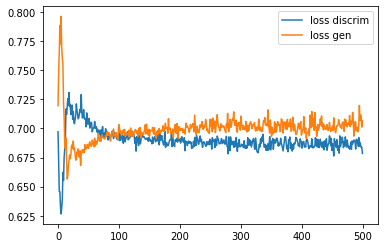

In [261]:
plt.plot(LD, label='loss discrim')
plt.plot(LG, label='loss gen')
plt.legend()

# Tests

In [176]:
def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # embedding on of new_word in the source space
    z = np.dot(W, x) # embedding of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(cosine_similarity(z.reshape(1,300),tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = cosine_similarity(z.reshape(1,300),tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

In [177]:
W_trained_test = gen.l1.weight.data

In [178]:
src_words = ['bateau', 'maison', 'argent', 'ordinateur', 'dieu']
tgt_words = []
for i in range(0,len(src_words)):
    top1, top5 = prediction(W_trained_test.numpy(), src_words[i], k=5) #top 1: english word (target)
    tgt_words.append(top1[0])
    print(top5)
    print('--')

['decent', 'ccc', 'understand', 'importantly', 'actually']
--
['christy', 'scene', 'returns', 'hideout', 'finds']
--
['std', 'romano', 'confessional', 'confess', 'defence']
--
['trivially', 'hence', 'itself', 'indeed', 'afaik']
--
['questioning', 'stressing', 'persuasion', 'contends', 'espoused']
--


In [127]:
# 2 possibles functions of accuracy = 
# - Test if we traduced well the word = sum Indicatrice(Wxi!=zi) (en gros nb de mots mal traduits) # en fait non c'est con on a pas les traductions
# - Test how far we are from the "supposed" translation
# compute Wxi find the closest z (SUPPOSED TO BE ITS TRANSLATION) and cumpute eculidian distance
def test_accuracy(X_text,W_trained):
    loss = 0
    for x in X_test : # get all french words
        word2id = {v: k for k, v in src_id2word.items()}
        word_emb_new = np.dot(W_trained, x)
        scores = (tgt_embeddings / np.linalg.norm(tgt_embeddings, 2, 1)[:, None]).dot(word_emb_new / np.linalg.norm(word_emb_new))
        best = scores.argsort()[-1:][::-1]
        nearest_eng_emb = src_embeddings[best]
        loss = loss + np.linalg.norm(word_emb_new-nearest_eng_emb)  
    return(loss)
    
# Pous savoir si le model est pertinent tester l'accuracy pour W_trained a epoch 1,5,10                             

In [130]:
rand_test_word_id = torch.Tensor(30).random_(nmax).long()
X_test = src_embeddings[rand_test_word_id.numpy()] # GARDER LES MEMES POUR LES TESTS

test_accuracy(X_test,W_trained_test)

209.139963900218

In [154]:
# construct a translation French to English dictionary
def prediction_dict(dico, W, k):
    dico_pred1 = {}
    dico_predk = {}
    i = 0
    for word in dico.keys() :
        if (i%100==0):
            print("Progress :", round(i/len(dico_test)*100,1), "%")
        dico_pred1[word], dico_predk[word] = prediction(W, word, k) # lists
        i += 1
    print("Done...")
    return dico_pred1, dico_predk

In [155]:
# k-top accuracy ("acc@k")
k = 5

dico_pred1, dico_predk = prediction_dict(dico_test, W_trained_test, k) 

Progress : 0.0 %
Progress : 6.7 %
Progress : 13.5 %
Progress : 20.2 %
Progress : 27.0 %
Progress : 33.7 %
Progress : 40.5 %
Progress : 47.2 %
Progress : 53.9 %
Progress : 60.7 %
Progress : 67.4 %
Progress : 74.2 %
Progress : 80.9 %
Progress : 87.7 %
Progress : 94.4 %
Done...


In [156]:
# measure of the accuracy of the dictionnary
# output is a list
def accuracy(dpred1, dpredk, dico):
    acc1 = [0]
    acck = [0]
    
    for key in dico.keys():
        add1, addk = 0, 0
        
        if dico[key] == dpred1[key][0]:
            add1 = 1
        acc1.append(acc1[-1] + add1)  
    
        for i in np.arange(k):
            if dico[key] == dpredk[key][i]:
                addk = 1
                break   
        acck.append(acck[-1] + addk) 
    
    acc1 = [i/len(dico) for i in acc1]   
    acck = [i/len(dico) for i in acck]
    
    return acc1, acck # nb de mots bien prédits/nb de mots total     

In [157]:
acc1_test, acck_test = accuracy(dico_pred1, dico_predk, dico_test)

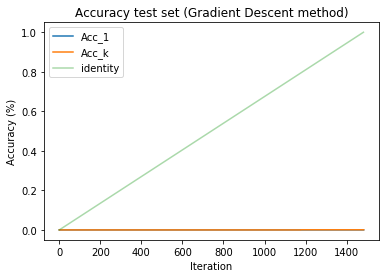

Gradient descent method :
Final accuracy @1 = 0.0 %
Final accuracy @5 = 0.07 %


In [159]:
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.plot([i/len(dico_test) for i in range(len(dico_test))],label="identity",alpha=0.4)
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set (Gradient Descent method)")
plt.legend()
plt.show()

print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")

## How to pair words

CSLS tentative

In [ ]:
k = 5 # hyper parameter K-NN
CSLS = np.zeros(nmax)

def CSLS_measure(W, new_word, k):
    x = src_embeddings[src_word2id[new_word]] # embeddings of new_word in the source space
    z = np.dot(W, x).reshape(-1,300) # embeddings of the translated word in the target space
    
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    for t in range(tgt_embeddings.shape[0]):
        dist_tgt_nn_z, index_tgt_nn_z = knn.kneighbors(z)
        emb_tgt_nn_z = tgt_embeddings[index_tgt_nn_z[0][:]].reshape(-1,300) # embeddings of the k-nn in the tgt space
        r_T = (1/k)*sum(cosine_similarity(z, emb_tgt_nn_z))
        
        dist_tgt_nn_yt, index_tgt_nn_yt = knn.kneighbors(tgt_embeddings[t])
        emb_tgt_nn_yt = tgt_embeddings[index_tgt_nn_yt[0][:]].reshape(-1,300) 
        r_S = (1/k)*sum(cosine_similarity(tgt_embeddings[t], emb_tgt_nn_yt))
        
        CSLS[t] = 2*cosine_similarity(z, tgt_embeddings[t]) - r_T - r_S
    CSLS = np.argmax(CSLS)
        
    return CSLS